# **Early proper time behaviour of beauty quark momentum broadening**

### Default simulation parameters for the Glasma and the Wong solvers

Simulation parameters chosen for a Glasma characterized by a saturation momentum $Q_s=2\,\mathrm{GeV}$ and a beauty quark.

In [2]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 2.0     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# Wong solver 
mass = 4.18      
tau_form = 0.02
pT = 0
ntp = 10**5  
nevents = 5    
representation = 'fundamental'      
boundary = 'periodic'       

### Set environment variables

In [3]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
from curraun.wong import init_mom_toy, init_pos, init_charge

Using CUDA
Using SU(3)
Using double precision
Using double precision


### Simulation routine for evolving the Glasma & solving Wong's equations
Computes and stores momentum broadening.

In [4]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad = np.zeros((maxt-formt, 4))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad"] = mom_broad

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

### Running the Wong solver over multiple Glasma events

In [5]:
mom_broads = []

for ev in range(nevents):
    output = simulate(ev)
    mom_broads.append(output["mom_broad"])

mom_broad = np.mean(mom_broads, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau = np.linspace(tau_form, tau_sim, maxt-formt)

output = {}
output["mom_broad"], output["tau"] = mom_broad, tau
output["Qs"], output["hbarc"] = Qs, hbarc

filename = 'wong_beauty.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 5: 100%|██████████| 819/819 [16:42<00:00,  1.22s/it]


## Read data from files using Julia

In [1]:
using Pickle

output = Pickle.npyload("results/wong_early_beauty.pickle")
mom_broad, tau = output["mom_broad"], output["tau"]
Qs, hbarc = output["Qs"], output["hbarc"]

(2, 0.197326)

### Plot transverse and longitudinal momentum broadenings, using Makie from Julia

In [2]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

string_as_varname (generic function with 1 method)

In [3]:
custom_colors = ["#9300d3", "#019d73", "#57b5e8"]

3-element Vector{String}:
 "#9300d3"
 "#019d73"
 "#57b5e8"

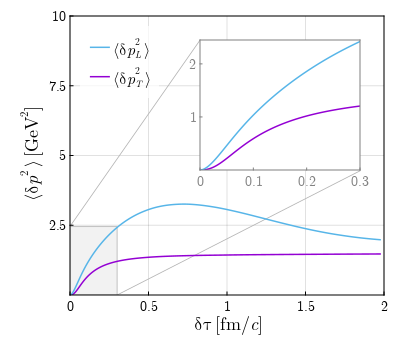

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000abcf510, 4000.0, 3500.0)


In [5]:
using CairoMakie
using ColorSchemes
using Makie.GeometryBasics
using ForwardDiff

colors = [custom_colors[1], custom_colors[2], custom_colors[3]]
width_line = 1.5

# dimenstion of fundamental representation for SU(3)
DR = 3

fig = Figure(resolution = (400, 350), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        xlabel=L"\delta \tau\,\mathrm{[fm/}c\mathrm{]}", ylabel=L"\langle \delta p^2\,\rangle\,\mathrm{[GeV^2]}",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xlabelpadding = -5)

poly!(axes, Rect(0, 0, 0.3, 2.45), color = :grey95, strokecolor = :grey70, strokewidth = 0.8)
lines!(axes, [0, 0.83], [2.46, 9.15], linewidth = 0.8, color=:grey70)
lines!(axes, [0.3, 1.85], [0, 4.46], linewidth = 0.8, color=:grey70)

perp = lines!(axes, tau.-tau[1], (mom_broad[:, 1]+mom_broad[:, 2])/DR, linewidth = width_line, color=colors[1])
paral = lines!(axes, tau.-tau[1], mom_broad[:, 3]/DR, linewidth = width_line, color=colors[3])

limits!(axes, 0, 2, 0, 10)
axes.xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
axes.yticks = ([2.5, 5, 7.5, 10], ["2.5", "5", "7.5", "10"])

ax_zoomin = Axis(fig, 
        bbox = BBox(200, 360, 180, 310), 
        # width=Relative(0.5), height=Relative(0.5), halign=0.9, valign=0.9, backgroundcolor=:white,
        xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=3, ytickalign=1, yticksize=3, xlabelpadding = -4, xgridvisible = false, ygridvisible = false,
        ytickcolor = :grey, xtickcolor = :grey, yticklabelcolor = :grey, xticklabelcolor = :grey, ylabelcolor = :grey, xlabelcolor = :grey,
        bottomspinecolor = :grey, topspinecolor = :grey, leftspinecolor = :grey, rightspinecolor = :grey)

translate!(ax_zoomin.elements[:background], 0, 0, 9)
translate!(ax_zoomin.scene, 0, 0, 10)

zoomin_indices = findall(t->t<=0.35, tau)
tau_zoomin = tau[zoomin_indices]
mom_broad_zoomin = mom_broad[zoomin_indices, :]
lines!(ax_zoomin, tau_zoomin.-tau[1], (mom_broad_zoomin[:, 1]+mom_broad_zoomin[:, 2])/DR, linewidth = width_line, color=colors[1])
lines!(ax_zoomin, tau_zoomin.-tau[1], mom_broad_zoomin[:, 3]/DR, linewidth = width_line, color=colors[3])
limits!(ax_zoomin, 0, 0.3, 0, 2.45)
ax_zoomin.xticks = ([0, 0.1, 0.2, 0.3], ["0", "0.1", "0.2", "0.3"])
ax_zoomin.yticks = ([1, 2], ["1","2"])

legend = [L"\langle\delta p_L^2\,\rangle", L"\langle\delta p_T^2\,\rangle"]
axislegend(axes, [paral, perp], legend, labelsize=16, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
# save("plots/beauty_early_behaviour_mom_broad.pdf", fig) 
save("plots/beauty_early_behaviour_mom_broad.png", fig, px_per_unit = 10.0) 

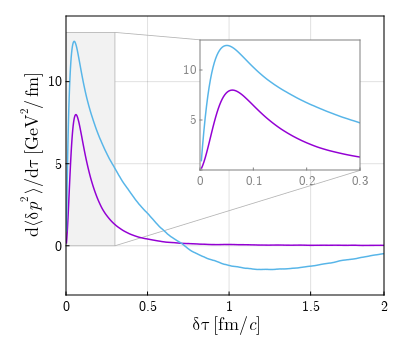

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000b2bf5b0, 4000.0, 3500.0)


In [6]:

fig = Figure(resolution = (400, 350), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        xlabel=L"\delta \tau\,\mathrm{[fm/}c\mathrm{]}", ylabel=L"\mathrm{d}\langle \delta p^2\,\rangle/\mathrm{d}\tau\,\mathrm{[GeV^2/\,fm]}",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xlabelpadding = -5) 

poly!(axes, Rect(0, 0, 0.3, 13), color = :grey95, strokecolor = :grey70, strokewidth = 0.8)
lines!(axes, [0.3, 0.82], [13, 12.55], linewidth = 0.8, color=:grey70)
lines!(axes, [0.3, 1.805], [0, 4.6], linewidth = 0.8, color=:grey70)

perp = lines!(axes, (tau.-tau[1])[2:length(tau)], diff((mom_broad[:, 1]+mom_broad[:, 2])/DR) ./ diff(tau), linewidth = width_line, color=colors[1])
paral = lines!(axes, (tau.-tau[1])[2:length(tau)], diff(mom_broad[:, 3]/DR) ./ diff(tau), linewidth = width_line, color=colors[3])

limits!(axes, 0, 1.95, -3, 14)
axes.xticks = ([0, 0.5, 1, 1.5, 1.95], ["0", "0.5", "1", "1.5", "2"])
axes.yticks = ([0, 5, 10], ["0", "5", "10"])

ax_zoomin = Axis(fig, bbox = BBox(200, 360, 180, 310), 
         xticklabelsize=13, yticklabelsize=13,
        xtickalign = 1, xticksize=3, ytickalign=1, yticksize=3, xlabelpadding = -4, xgridvisible = false, ygridvisible = false,
        ytickcolor = :grey, xtickcolor = :grey, yticklabelcolor = :grey, xticklabelcolor = :grey, ylabelcolor = :grey, xlabelcolor = :grey,
        bottomspinecolor = :grey, topspinecolor = :grey, leftspinecolor = :grey, rightspinecolor = :grey)

zoomin_indices = findall(t->t<=0.35, tau)
tau_zoomin = tau[zoomin_indices]
mom_broad_zoomin = mom_broad[zoomin_indices, :]
lines!(ax_zoomin, (tau_zoomin.-tau[1])[2:length(tau_zoomin)], diff((mom_broad_zoomin[:, 1]+mom_broad_zoomin[:, 2])/DR) ./ diff(tau_zoomin), linewidth = width_line, color=colors[1])
lines!(ax_zoomin, (tau_zoomin.-tau[1])[2:length(tau_zoomin)], diff(mom_broad_zoomin[:, 3]/DR) ./ diff(tau_zoomin), linewidth = width_line, color=colors[3])
limits!(ax_zoomin, 0, 0.3, 0, 13)
ax_zoomin.xticks = ([0, 0.1, 0.2, 0.3], ["0", "0.1", "0.2", "0.3"])
ax_zoomin.yticks = ([0, 5, 10], ["","5", "10"])

translate!(ax_zoomin.elements[:background], 0, 0, 9)
translate!(ax_zoomin.scene, 0, 0, 10)

# legend = [L"\langle\delta p_L^2\,\rangle", L"\langle\delta p_T^2\,\rangle"]
# axislegend(axes, [paral, perp], legend, labelsize=16, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
# save("plots/beauty_early_behaviour_kappa.pdf", fig) 
save("plots/beauty_early_behaviour_kappa.png", fig, px_per_unit = 10.0) 